In [18]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pk
import xarray
import pandas as pd

from shapely.geometry import Polygon
from shapely.geometry.point import Point
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
from matplotlib import cm

def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]

 # Convert CH y/x to WGS lat
def CHtoWGSlat(y, x):
    # Axiliary values (% Bern)
    y_aux = (y - 600000) / 1000000
    x_aux = (x - 200000) / 1000000
    lat = (16.9023892 + (3.238272 * x_aux)) + \
            - (0.270978 * pow(y_aux, 2)) + \
            - (0.002528 * pow(x_aux, 2)) + \
            - (0.0447 * pow(y_aux, 2) * x_aux) + \
            - (0.0140 * pow(x_aux, 3))
    # Unit 10000" to 1" and convert seconds to degrees (dec)
    lat = (lat * 100) / 36
    return lat

# Convert CH y/x to WGS long
def CHtoWGSlng(y, x):
    # Axiliary values (% Bern)
    y_aux = (y - 600000) / 1000000
    x_aux = (x - 200000) / 1000000
    lng = (2.6779094 + (4.728982 * y_aux) + \
            + (0.791484 * y_aux * x_aux) + \
            + (0.1306 * y_aux * pow(x_aux, 2))) + \
            - (0.0436 * pow(y_aux, 3))
    # Unit 10000" to 1" and convert seconds to degrees (dec)
    lng = (lng * 100) / 36
    return lng

class StadiaStamen(cimgt.Stamen):
    def _image_url(self, tile):
         x,y,z = tile
         url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain_background/{z}/{x}/{y}.png?api_key={'9fef28bc-9f41-4947-b140-1152be1fc0a0'}"
         return url

In [3]:
#Test read of one file
df = pd.read_csv('/data/hail/TRT_Cell_ID-2021062010000041/CZC2117110000T.trt', index_col=None, sep=';',skiprows=9,names=['ID', 'time', 'lat', 'lon'],usecols=[0,1,2,3])

In [4]:
#Load TRT data to plot the supercell track
path = '/data/hail/TRT_Cell_ID-2021062010000041/' # use your path
all_files = glob.glob(os.path.join(path , '*.trt'))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, sep=';',skiprows=9,names=['ID', 'time', 'lon', 'lat'],usecols=[0,1,2,3])
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

dft = frame.loc[frame['ID'] == 2021062010000041]
dft['time'] = dft['time'].astype(str)
dft['datetime'] = pd.to_datetime(dft['time'])
dft = dft.set_index(['datetime'])
del dft['time']
dft.sort_values(by='datetime', inplace = True)

/tmp/ipykernel_10197/147467778.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['time'] = dft['time'].astype(str)
/tmp/ipykernel_10197/147467778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['datetime'] = pd.to_datetime(dft['time'])


In [4]:
points = gpd.GeoSeries([Point(9., 47.7), Point(10., 47.7)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
print(distance_meters)

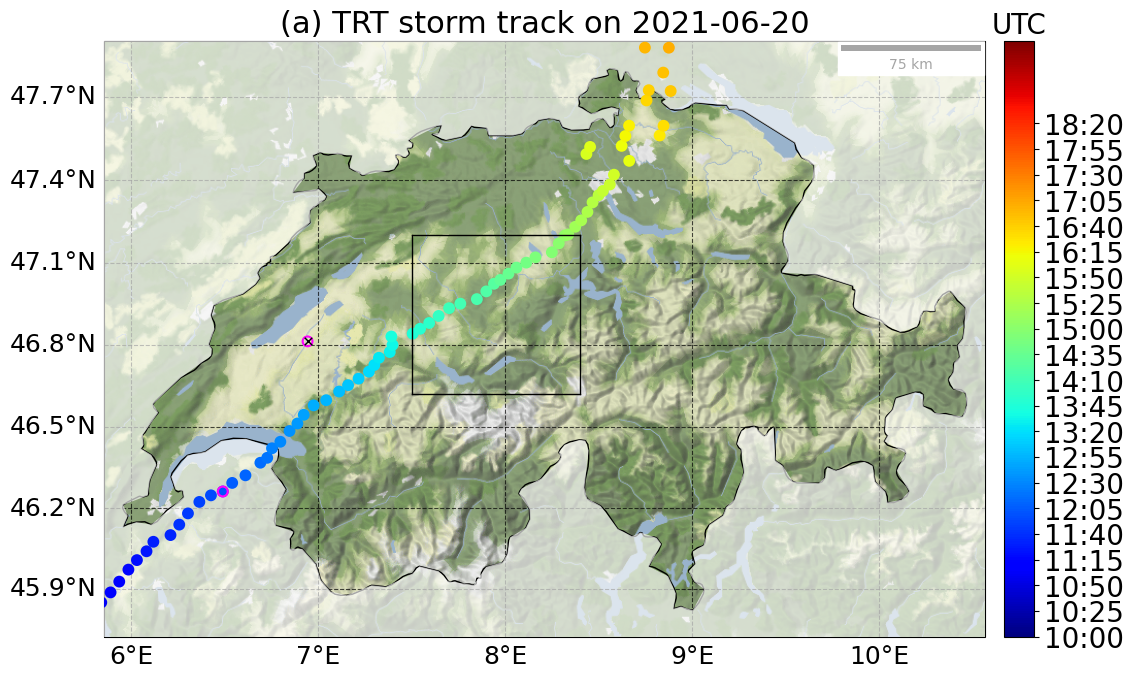

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# request data for use by geopandas
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry of a country
poly = [df.loc[df['ADMIN'] == 'Switzerland']['geometry'].values[0]]

stamen_terrain = StadiaStamen('terrain-background')

# projections that involved
st_proj = stamen_terrain.crs  #projection used by Stamen images
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat

# create fig and axes using intended projection
fig = plt.figure(figsize=(8*1.5,6*1.5))
ax = fig.add_subplot(1, 1, 1, projection=st_proj)

ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')

pad1 = .1  #padding, degrees unit
exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
ax.set_extent(exts, crs=ll_proj)

# make a mask polygon by polygon's difference operation
# base polygon is a rectangle, another polygon is simplified switzerland
msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
msk_stm  = st_proj.project_geometry (msk, ll_proj)  # project geometry to the projection used by stamen

# get and plot Stamen images
ax.add_image(stamen_terrain, 8) # this requests image, and plot

# plot the mask using semi-transparency (alpha=0.65) on the masked-out portion
ax.add_geometries(msk_stm, st_proj, zorder=12, facecolor='white', edgecolor='none', alpha=0.65)

smap = ax.scatter(dft['lon'],dft['lat'],c=dft.index,zorder=159,transform=ll_proj,linewidth=2.5,cmap='jet')

#Add location of Payerne station
ax.scatter(6.9437, 46.8131, s=50, facecolors='none', edgecolors='magenta', zorder=160, transform=ll_proj, linewidth=1.5)
ax.scatter(6.9437, 46.8131, s=30, marker='x', color='black', zorder=161, transform=ll_proj, linewidth=1.0)

ax.scatter(dft.loc['2021-06-20 12:00:00']['lon'], dft.loc['2021-06-20 12:00:00']['lat'], s=50, facecolors='none', edgecolors='magenta', zorder=160, transform=ll_proj, linewidth=1.5)

ax.plot(np.array([7.5, 8.4]),np.array([46.62, 46.62]), color='black', zorder=160, transform=ll_proj, linewidth=1)
ax.plot(np.array([7.5, 8.4]),np.array([47.2, 47.2]), color='black', zorder=160, transform=ll_proj, linewidth=1)

ax.plot(np.array([7.5, 7.5]),np.array([46.62, 47.2]), color='black', zorder=160, transform=ll_proj, linewidth=1)
ax.plot(np.array([8.4, 8.4]),np.array([46.62, 47.2]), color='black', zorder=160, transform=ll_proj, linewidth=1)

N_TICKS = 21
indexes = [dft.index[i] for i in np.linspace(0,dft.shape[0]-17,N_TICKS).astype(int)] 

cb = fig.colorbar(smap, orientation='vertical',
                  ticks= dft.loc[indexes].index.astype(int), fraction=0.032, pad=0.02)

cb.ax.set_yticklabels([index.strftime('%H:%M') for index in indexes],fontsize=20)
cb.ax.set_title('UTC',fontsize=20)
ax.set_title('(a) TRT storm track on 2021-06-20',fontsize=22)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)

gl = ax.gridlines(draw_labels=True, linestyle='--',color='black',alpha=0.7)
gl.xlabel_style = {'size': 18, 'color': 'k'}
gl.ylabel_style = {'color': 'k', 'size':18}


ax.add_artist(ScaleBar(0.9))

gl.top_labels = False
gl.right_labels = False

plt.savefig('/data/hail/plots/figure_2a_REV.png',bbox_inches='tight', dpi=300)

In [7]:
#Load MESHS data
with open('cache/di.pk','rb') as f:
    di = pk.load(f)
    
meshs = np.asarray(di['data_vars']['maximum_expected_severe_hail_size']['data'])
meshs = np.reshape(meshs, [640,710])
lat = np.asarray(di['coords']['lat']['data'])
lon = np.asarray(di['coords']['lon']['data'])
x = np.asarray(di['coords']['x']['data'])
y = np.asarray(di['coords']['y']['data'])

x_c = x + 600000
y_c = y + 200000

co = []
for xi in x_c:
    for yi in y_c:
        co.append([yi,xi])
co = np.asarray(co)

y2 = co[:][:,0]
x2 = co[:][:,1]

lat_c = []
lon_c = []

for i,x in enumerate(x2):
    y=y2[i]
    lat_c.append(CHtoWGSlat(x, y))
    lon_c.append(CHtoWGSlng(x, y))
    
lat_m = np.asarray(lat_c)
lon_m = np.asarray(lon_c)    

In [8]:
co_wgs = []
for xi in x_c:
    for yi in y_c:
        co_wgs.append([CHtoWGSlat(xi, yi),CHtoWGSlng(xi, yi)])
co_wgs = np.asarray(co_wgs)

In [9]:
meshs_c = np.reshape(meshs,[640*710],order='C')
exts = [7.5, 8.4, 46.62, 47.2]

i1 = np.where(np.logical_and([co_wgs[:][:,0] >= exts[2]], [co_wgs[:][:,0] <= exts[3]]))[1]

o_wgs_tmp = co_wgs[i1]
meshs_c_tmp = meshs_c[i1]

i2 = np.where(np.logical_and([co_wgs_tmp[:][:,1] >= exts[0]], [co_wgs_tmp[:][:,1] <= exts[1]]))[1]

co_wgs_final = co_wgs_tmp[i2]
meshs_c_final = meshs_c_tmp[i2]

print(np.nanmax(meshs_c_final))

NameError: name 'co_wgs_tmp' is not defined

In [250]:
co_wgs_final[:][:,0]

array([46.62272621, 46.63172176, 46.64071731, ..., 46.69966069,
       46.70865552, 46.71765033])

In [164]:
ind_lat = np.where(np.logical_and(lat_m > exts[2], lat_m < exts[3]))[0]
ind_lon = np.where(np.logical_and(lon_m > exts[0], lon_m < exts[1]))[0]

In [182]:
tmplat = lat_m[ind_lat]
tmplon = lon_m[ind_lon]

In [120]:
lon_m2 = np.reshape(lon_m,[710,640])
lon_m2 = lon_m2[:,0]
lat_m2 = lat_m[0:640]

In [281]:
meshs_c_final.repeat(2, axis=0)

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
#Import hailsensor data for 20210620 from csv file
path_crowd = 'cache/crowdsourced_data.csv'

dat = pd.read_csv(path_crowd)
dat = dat[dat['days'] == '2021-06-20']
dat = dat[dat['FILTEREDOUT'] == 0]
dat = dat[dat['size_text'] != 'No hail']

lat_crowd = dat['Lat'].values
lon_crowd = dat['Lon'].values
size_crowd = dat['size_number'].values
size_mm = dat['size_mm'].values

/tmp/ipykernel_10197/9103442.py:74: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', fraction=0.04, pad=0.02,alpha=1)


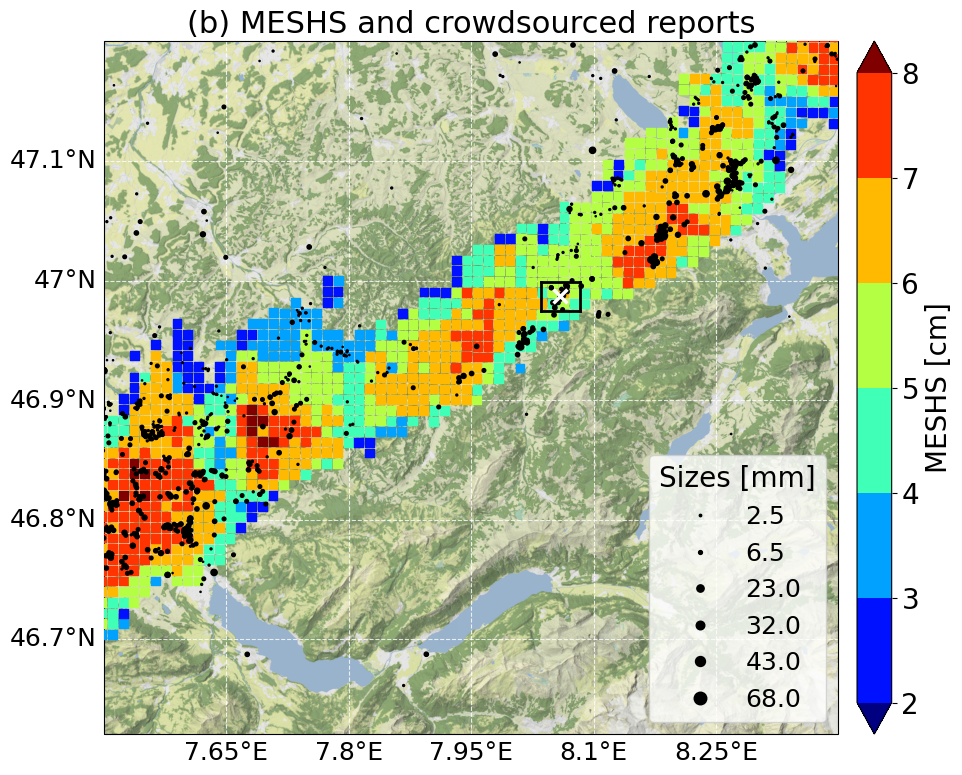

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# request data for use by geopandas
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry of a country
poly = [df.loc[df['ADMIN'] == 'Switzerland']['geometry'].values[0]]

stamen_terrain = StadiaStamen('terrain-background')

# projections that involved
st_proj = stamen_terrain.crs  #projection used by Stamen images
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat

# create fig and axes using intended projection
fig = plt.figure(figsize=(8*1.5,6*1.5))

ax = fig.add_subplot(1, 1, 1, projection=st_proj)

ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')

pad1 = .1  #padding, degrees unit
exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];

exts = [7.5, 8.4, 46.62, 47.2]
#exts = [5, 10, 45.62, 48.2]
ax.set_extent(exts, crs=ll_proj)

# make a mask polygon by polygon's difference operation
# base polygon is a rectangle, another polygon is simplified switzerland
#msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
#msk_stm  = st_proj.project_geometry (msk, ll_proj)  # project geometry to the projection used by stamen

# get and plot Stamen images
ax.add_image(stamen_terrain, 14) # this requests image, and plot

# plot the mask using semi-transparency (alpha=0.65) on the masked-out portion
#ax.add_geometries( msk_stm, st_proj, zorder=12, facecolor='white', edgecolor='none', alpha=0.65)

cmap = mpl.cm.jet
bounds = [2, 3, 4, 5, 6, 7, 8]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

#mesh_map = ax.contourf(co_wgs_final[:][:,0], co_wgs_final[:][:,1], mm, zorder=159, transform=ll_proj, cmap=cmap, norm=norm, alpha=0.8)

ax.scatter(lon_m, lat_m, s=40, c=np.transpose(meshs), marker='s', zorder=159, transform=ll_proj, cmap=cmap, norm=norm, alpha=1)

scatter = ax.scatter(lon_crowd, lat_crowd, s=size_crowd*1.2, color='black', marker='.', zorder=165, transform=ll_proj)

handles, labels = scatter.legend_elements(prop="sizes", alpha=1)
labels = ['$\\mathdefault{2.5}$',
 '$\\mathdefault{6.5}$',
 '$\\mathdefault{23.0}$',
 '$\\mathdefault{32.0}$',
 '$\\mathdefault{43.0}$',
 '$\\mathdefault{68.0}$']

legend2 = ax.legend(handles, labels, loc="lower right", title="Sizes [mm]", fontsize=18, title_fontsize=20)

#Add soccer field marker to map plot
ax.scatter(8.05942,46.98709, s=100, marker='x', color='white', zorder=170, transform=ll_proj, linewidth=2.5)

ax.plot(np.array([8.035, 8.0834]),np.array([46.975, 46.975]), color='black', zorder=180, transform=ll_proj, linewidth=2)
ax.plot(np.array([8.035, 8.0834]),np.array([46.9991, 46.9991]), color='black', zorder=180, transform=ll_proj, linewidth=2)

ax.plot(np.array([8.035, 8.035]),np.array([46.975, 46.9991]), color='black', zorder=180, transform=ll_proj, linewidth=2)
ax.plot(np.array([8.0834, 8.0834]),np.array([46.975, 46.9991]), color='black', zorder=180, transform=ll_proj, linewidth=2)


cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', fraction=0.04, pad=0.02,alpha=1)

#cb.ax.set_title('UTC')
ax.set_title('(b) MESHS and crowdsourced reports', fontsize=22)
gl = ax.gridlines(draw_labels=True, linestyle='--',color='white',alpha=0.8)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
cb.ax.yaxis.set_tick_params(labelsize=20)
cb.set_label(label='MESHS [cm]', size=20)
#cb.ax.tick_params(labelsize=20)

#ax.add_artist(ScaleBar(0.5,location='lower right'))

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 18, 'color': 'k'}
gl.ylabel_style = {'color': 'k', 'size':18}

plt.savefig('/data/hail/plots/figure_2b_REV.png',bbox_inches='tight', dpi=300)

In [15]:
labels

['$\\mathdefault{3.0}$',
 '$\\mathdefault{7.8}$',
 '$\\mathdefault{27.6}$',
 '$\\mathdefault{38.4}$',
 '$\\mathdefault{51.6}$',
 '$\\mathdefault{81.6}$']

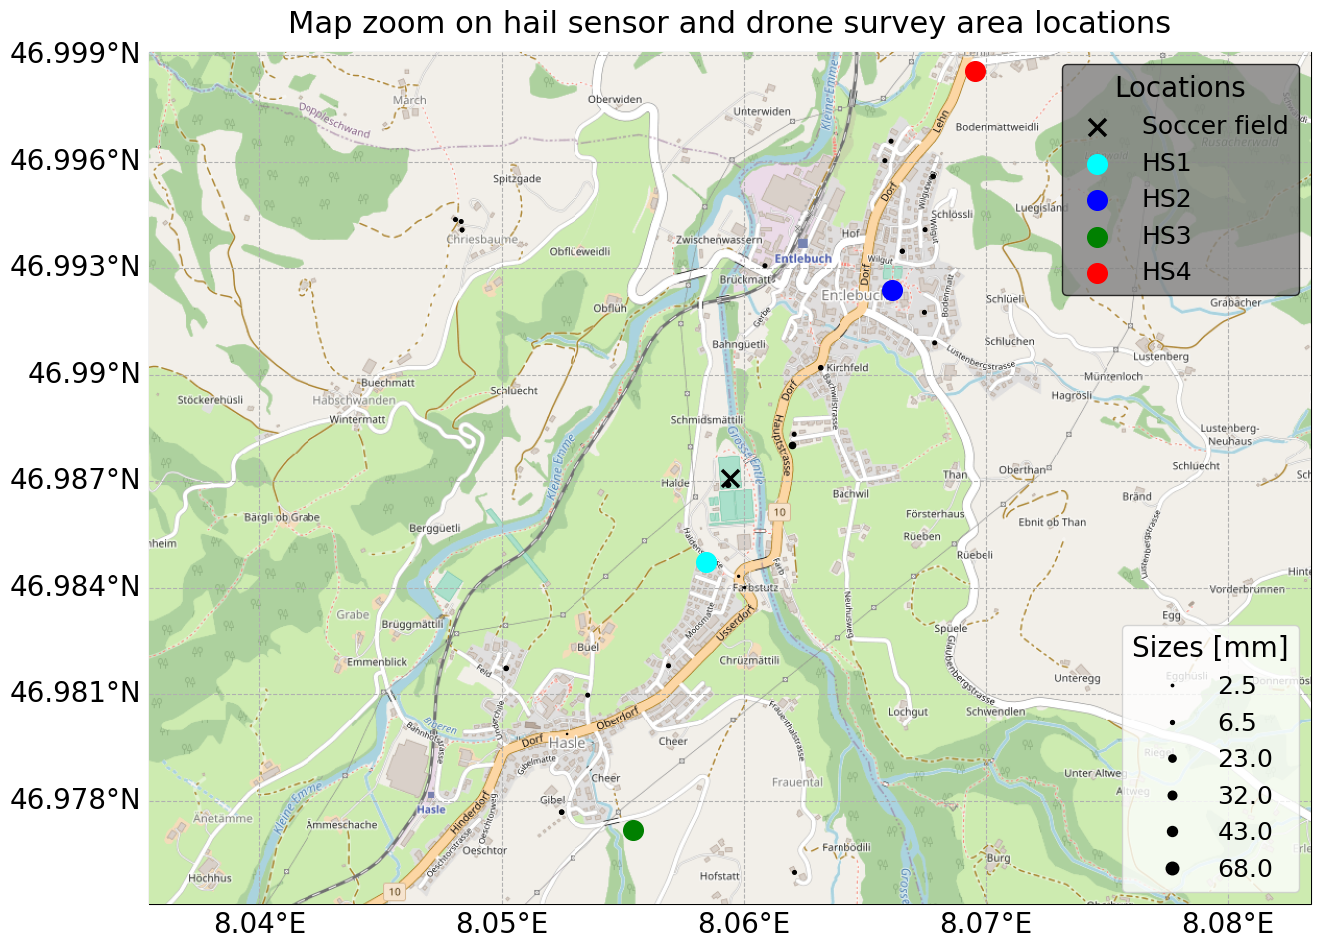

In [38]:
import matplotlib.pyplot as plt 
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

fig = plt.figure(figsize=(15,12)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [46.98709, 8.05942] # lat/lon of One World Trade Center in NYC
zoom = 0.012 # for zooming out of center point
extent = [center_pt[1]-(zoom*2.0),center_pt[1]+(zoom*2.0),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
#extent = [8.045, 8.07, 46.975, 47]
ax1.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale),zorder=3) # add OSM with zoom specification
# NOTE: zoom specifications should be selected based on extent:
# -- 2     = coarse image, select for worldwide or continental scales
# -- 4-6   = medium coarseness, select for countries and larger states
# -- 6-10  = medium fineness, select for smaller states, regions, and cities
# -- 10-12 = fine image, select for city boundaries and zip codes
# -- 14+   = extremely fine image, select for roads, blocks, buildings

#Add soccer field marker to map plot
p1 = ax1.scatter(8.05942, 46.98709, s=150, marker='x', transform=ll_proj, color='black', zorder=10,label='Soccer field',linewidth=2.5)
p2 = ax1.scatter(8.05845, 46.98472, s=800, marker='.', transform=ll_proj, color='cyan', zorder=10, label='HS1')
p3 = ax1.scatter(8.066133233, 46.99239625, s=800, marker='.', transform=ll_proj, color='blue', zorder=10, label='HS2')
p4 = ax1.scatter(8.055425364, 46.97717202, s=800, marker='.', transform=ll_proj, color='green', zorder=10, label='HS3')
p5 = ax1.scatter(8.06953946, 46.99854751, s=800, marker='.', transform=ll_proj, color='red', zorder=10, label='HS4')

gl = ax1.gridlines(draw_labels=True,zorder=4,linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20, 'color': 'k'}
gl.ylabel_style = {'color': 'k', 'size':20}

first_legend = plt.legend(handles=[p1,p2,p3,p4,p5], loc=1,title='Locations',facecolor='grey', framealpha=0.8, edgecolor='black', fontsize=18, title_fontsize=20)
#ax1.legend(title='Hail sensors',facecolor='grey', framealpha=0.4,edgecolor='black')
# Add the legend manually to the current Axes.
ax1.add_artist(first_legend)

scatter = ax1.scatter(lon_crowd, lat_crowd, s=size_crowd*1.2, color='black', marker='.', zorder=12, transform=ll_proj)
handles, labels = scatter.legend_elements(prop="sizes", alpha=1)
labels = ['$\\mathdefault{2.5}$',
 '$\\mathdefault{6.5}$',
 '$\\mathdefault{23.0}$',
 '$\\mathdefault{32.0}$',
 '$\\mathdefault{43.0}$',
 '$\\mathdefault{68.0}$']

legend2 = ax1.legend(handles, labels, loc="lower right", title="Sizes [mm]", fontsize=18, title_fontsize=20)
ax1.set_title('Map zoom on hail sensor and drone survey area locations', fontsize=22)

ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

plt.savefig('figure_2c_REV.png',bbox_inches='tight', dpi=300)

In [4]:
#Plot sensor distributions with infos about max(MESHS)
#Import hailsensor data for 20210620 from csv file
path_sen = '/home/martin/container/hail/sensors_martin.csv'
dat = pd.read_csv(path_sen)
dat = dat[dat['days'] == '2021-06-20']

#Get HS data from four closest sensors
#Sensor1
dat_schENT = dat[dat['sensorName'] == 'SchulhausENTLEBUCH']
hs2 = dat_schENT['diameter'].values

#Sensor2
dat_lusENT = dat[dat['sensorName'] == 'LustenbergerENTLEBUCH']
hs4 = dat_lusENT['diameter'].values

#Sensor3
dat_wasHAS = dat[dat['sensorName'] == 'WasserHASLE']
hs3 = dat_wasHAS['diameter'].values[0:-1]

#Sensor4 - kein Einschlag
dat_porHAS = dat[dat['sensorName'] == 'PortmannHASLE']
hs1 = dat_porHAS['diameter'].values

In [8]:
dat_wasHAS['Time'].values[0][0:19]

'2021-06-20 14:16:40'

In [11]:
dat_wasHAS['Time'].values[-1][0:19]

'2021-06-20 15:09:10'

In [14]:
datetime.strptime(dat_wasHAS['Time'].values[0][0:19], '%Y-%m-%d %H:%M:%S')

datetime.datetime(2021, 6, 20, 14, 16, 40)

In [24]:
from datetime import timedelta, datetime
diff = datetime.strptime(dat_wasHAS['Time'].values[31][0:19], '%Y-%m-%d %H:%M:%S') - datetime.strptime(dat_wasHAS['Time'].values[0][0:19], '%Y-%m-%d %H:%M:%S') 

In [26]:
diff.total_seconds() / 60

16.45

In [18]:
dat_wasHAS['Time'].values[0]

'2021-06-20 14:16:40.923000'

In [30]:
np.size(hs3)

32

In [19]:
dat_wasHAS['Time'].values[18]

'2021-06-20 14:25:50.189000'

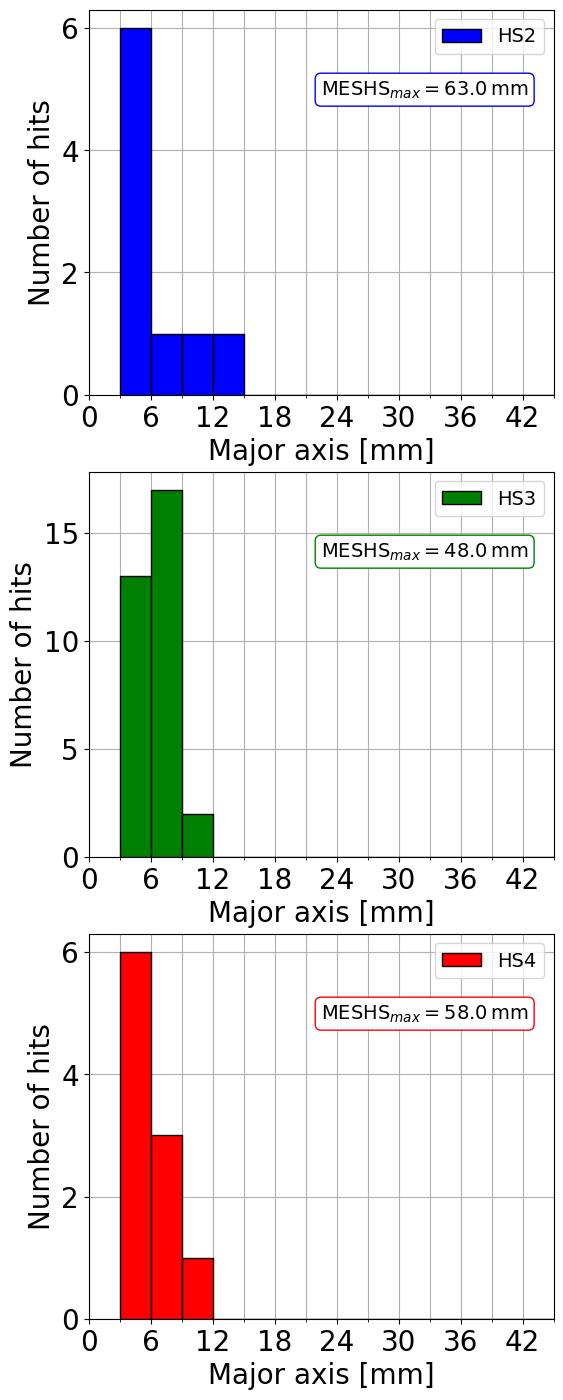

In [31]:
num_rows, num_cols = 3, 1

hs2_m = dat_schENT['meshs_sensorpix'].values *10
hs3_m = dat_wasHAS['meshs_sensorpix'].values *10
hs4_m = dat_lusENT['meshs_sensorpix'].values *10

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 17
                                                     ))

x = [hs2,hs3,hs4]
xm = [hs2_m,hs3_m,hs4_m]
col=['blue','green','red']
lab=['HS2','HS3','HS4']
c=0
numBins = 18

for i in range(num_rows):
    textstr = 'MESHS$_{max}=%.1f\,$mm' % (np.max(xm[i]), )
    props = dict(boxstyle='round', edgecolor=col[i],facecolor='white', alpha=1)
    axes[i].text(0.5, 0.82, textstr, transform=axes[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=props, zorder=12, color='black')
    
    axes[i].hist(x[c],numBins,range=[3,45+12],color=col[c],alpha=1, edgecolor='black',density=False,zorder=10,label=lab[c])
    
    #axes[i].hist(xm[c],numBins,range=[3,45+12],color=col[c],alpha=0.5, edgecolor='cyan',density=False,zorder=10,label=lab[c])
    axes[i].set_xlabel('Major axis [mm]', fontsize=20)
    axes[i].set_ylabel('Number of hits', fontsize=20)
    axes[i].set_xlim([0,45])
    axes[i].set_xticks(np.linspace(0,42,8))
    plt.setp(axes[i].get_xticklabels(), fontsize=20)
    plt.setp(axes[i].get_yticklabels(), fontsize=20)
    #axes[i].set_xticklabels(np.int(np.linspace(0,42,8)), fontsize=12)
    axes[i].set_xticks([3, 9, 15, 21, 27, 33, 39, 45], minor=True)
    #axes[i].minorticks_on()
    axes[i].grid(which='both',zorder=5)
    axes[i].legend(fontsize=14)
    axes[i].xaxis.set_tick_params(labelsize=20)
    axes[i].yaxis.set_tick_params(labelsize=20)
    c=c+1
    #axes[i, j].set(title=t, xticks=[-4, 0, 4], yticks=[])
#axes[0].set_title('(d)',fontsize=22)    
plt.savefig('figure_4.png',bbox_inches='tight', dpi=300)

In [453]:
dat_wasHAS.keys()

Index(['Unnamed: 0', 'Event_ID', 'sensorName', 'days', 'Time', 'CHX', 'CHY',
       'calib_factor', 'diameter', 'digits', 'kin_energy', 'status',
       'maxpoh_rad10', 'poh_sensorpix', 'maxmeshs_rad10', 'meshs_sensorpix',
       'maxczc_rad10', 'czc_sensorpix', 'time_received', 'months', 'years',
       'rad_timestamp', 'Lat', 'Lon', 'daily_count_by_sensor', 'kin_energy_H',
       'Time2', 'dt', 'Event_start', 'Event_end', 'Event_duration',
       'Event_hits', 'Event_hit_frequency', 'Event_KEdensity_tot',
       'Event_KEFlux_tot', 'Event_KE_max', 'Event_D_max',
       'Event_D_max_vicinity', 'Event_count', 'meanPOHrad10_ev',
       'meanPOHpix_ev', 'meanCZCrad10_ev', 'meanCZCpix_ev',
       'meanMESHSrad10_ev', 'meanMESHSpix_ev'],
      dtype='object')

In [461]:
hs2_m = dat_schENT['meshs_sensorpix'].values *10
hs3_m = dat_wasHAS['meshs_sensorpix'].values *10
hs4_m = dat_lusENT['meshs_sensorpix'].values *10

In [70]:
np.linspace(0,42,8)

array([ 0.,  6., 12., 18., 24., 30., 36., 42.])

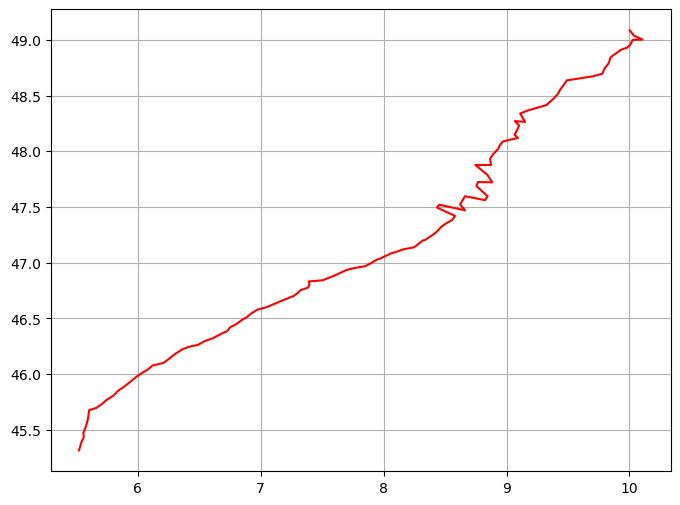

In [90]:
#Storm track fast plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dft['lat'],dft['lon'],color='red',zorder=10090990)
#ax.set_xticks(np.linspace(5,11,12))
ax.grid(which='both')

/store/msrad/utils/anaconda3-mlainer/envs/pyrad/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/store/msrad/utils/anaconda3-mlainer/envs/pyrad/lib/python3.9/site-packages/mpl_toolkits/basemap/__init__.py:4794: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


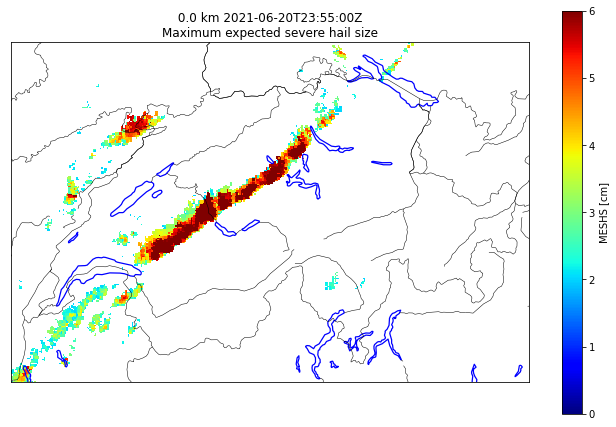

In [9]:
display = pyart.graph.GridMapDisplayBasemap(data_mzc)

# create the figure
font = {'size': 10}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[10, 8])

# Add Basic Title
#title = 'Basic Plot with Overlay Example Title'
#     Xleft%, ybot%
#fig.text(0.5, 0.9, title, horizontalalignment='center', fontsize=24)

# panel sizes      xleft%, ybot%, xright% ,ytop%
map_panel_axes = [0.05, 0.15, 0.9, 0.7]
colorbar_panel_axes = [0.15, 0.09, 0.7, .010]

# parameters
level = 0
vmin = 0
vmax = 6

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)

ax1 = display.plot_basemap(resolution='h',auto_range=False, min_lat=45.7, max_lat=47.9, min_lon=5.7, max_lon=10.6)

display.plot_grid('maximum_expected_severe_hail_size', level=level, cmap='jet',vmin=vmin, vmax=vmax, title_flag=True,
                colorbar_flag=True, colorbar_label='MESHS [cm]', axislabels_flag=False)

In [7]:
lon = data_mzc.get_point_longitude_latitude()[0]
lat = data_mzc.get_point_longitude_latitude()[1]

/store/msrad/utils/anaconda3-mlainer/envs/pyrad/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/store/msrad/utils/anaconda3-mlainer/envs/pyrad/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [8]:
meshs = data_mzc.fields['maximum_expected_severe_hail_size']['data']
meshs = np.reshape(meshs,[640,710])